# Some examples of image manipulation for evaluating OCR

In [4]:
import cv2                      # Computer Vision
import numpy as np              # Vector math
import matplotlib.pyplot as plt # Plotting
%matplotlib inline

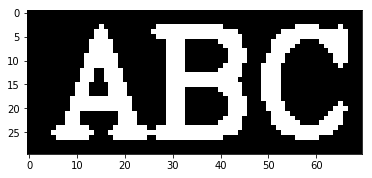

In [28]:
img = np.asarray(cv2.putText(np.zeros((30, 70)), "ABC", (5, 25), cv2.FONT_HERSHEY_COMPLEX,
                             1.0, (255, 255, 255), 2, cv2.LINE_AA)
                 , dtype=np.uint8)

plt.imshow(img, cmap='gray');

In [29]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

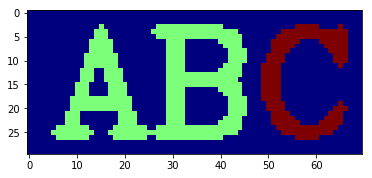

In [54]:
_, cc = cv2.connectedComponents(img, connectivity=4)
plt.imshow(cc, cmap='jet')



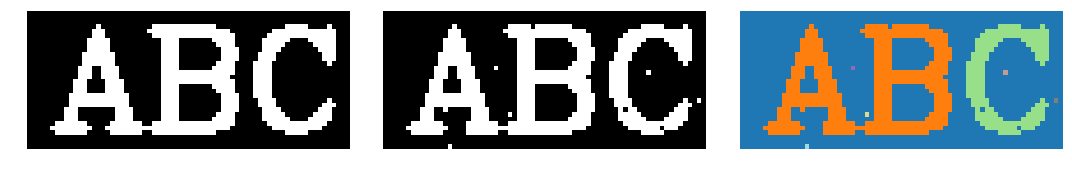

In [104]:
img_sp = img.copy()
for i in range(10):
    a = np.random.randint(img_sp.shape[0])
    b = np.random.randint(img_sp.shape[1])
    if img_sp[a, b] == 0:
        img_sp[a, b] = 255
    else:
        img_sp[a, b] = 0
    #print("Changing img_sp[%i, %i]" % (a, b))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(img_sp, cmap='gray')
plt.axis('off');
plt.subplot(1, 3, 3)
_, cc = cv2.connectedComponents(img_sp, connectivity=4)
plt.imshow(cc, cmap='tab20')
plt.axis('off');
plt.tight_layout()
plt.show()

In [ ]:
# Median filtering

In [ ]:
# Blurring

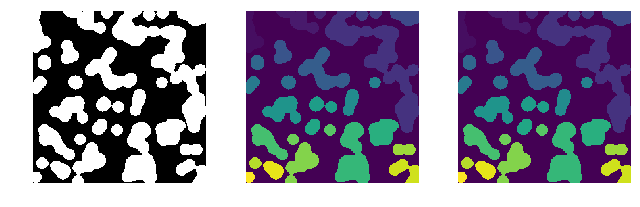

In [34]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

n = 12
l = 256
np.random.seed(1)
im = np.zeros((l, l))
points = l * np.random.random((2, n ** 2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = filters.gaussian(im, sigma= l / (4. * n))
blobs = im > 0.7 * im.mean()

all_labels = measure.label(blobs)
blobs_labels = measure.label(blobs, background=0)

